# Synapse Prediction

In [8]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from category_encoders import TargetEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GridSearchCV

from scipy.spatial import distance

import os
import warnings
warnings.filterwarnings("ignore")

# Supporting Functions

In [5]:
def plot_feature_importances(model):
    '''
    Visualization for future importance
    '''
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [12]:
def compute_average_neuronal_density(df):
    coords = df[['axonal_coor_x','axonal_coor_y','axonal_coor_x']].values
    all_distances = []

    # Iterate through each neuron
    for i, neuron in enumerate(coords):
        other_neurons = np.delete(coords, i, axis=0)  # Exclude the current neuron
        dist_to_other_neurons = distance.cdist([neuron], other_neurons)[0]
        all_distances.extend(dist_to_other_neurons)

    # Compute the average distribution of distances
    average_distances = np.mean(all_distances, axis=0)

    # Plot the average distribution of distances
    plt.hist(average_distances, bins=30, edgecolor='black')
    plt.xlabel('Average Distance to Other Neurons')
    plt.ylabel('Frequency')
    plt.title('Average Neuronal Density Distribution')
    plt.show()

## Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir(r'C:\Users\danie\OneDrive\Desktop\Fall2023\ELEC478\Competition\neuron-synapse-prediction')
 
#load in training data on each potential synapse
data = pd.read_csv("./train_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("./feature_weights.csv")
morph_embeddings = pd.read_csv("./morph_embeddings.csv")

#### Basic info on these dataframes

In [7]:
print("Main Dataframe Size:",data.shape)
print("\nMain Dataframe:")
data.info()

print("\nFeature Weights Size:",feature_weights.shape)
print("\nFeature Weights:")
feature_weights.info(verbose=False)

print("\nMorphological Embeddings Size:",morph_embeddings.shape)
print("\nMorphological Embeddings:")
morph_embeddings.info(verbose=False)

Main Dataframe Size: (185832, 30)

Main Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185832 entries, 0 to 185831
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score             

In [13]:
compute_average_neuronal_density(data)

In [11]:
data[['axonal_coor_x','axonal_coor_y','axonal_coor_x']]

,axonal_coor_x,axonal_coor_y,axonal_coor_x
0,1187660,411978,1187660
1,1204580,682542,1204580
2,1191790,403683,1191790
3,1184320,419286,1184320
4,1189150,673302,1189150
...,...,...,...
185827,1260230,553602,1260230
185828,1214580,405321,1214580
185829,1223920,375081,1223920
185830,1253490,387870,1253490


In [139]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

In [140]:
data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

## Feature Engineering

In [141]:
#cosine similarity function
def row_feature_similarity(row):
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

In [142]:
#cosine similarity function
def row_morph_similarity(row):
    pre = row["pre_morph_embeddings"]
    post = row["post_morph_embeddings"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

In [146]:
def feature_engineering(data, one_hot = False, me_similarity = True):
    # compute the cosine similarity between the pre- and post- feature weights
    data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)  

    if me_similarity:
        data['me_similarity'] = data.apply(row_morph_similarity, axis=1)  
        #Use mean to fill NaN values
        data['me_similarity'] = data['me_similarity'].fillna(np.mean(data['me_similarity'].dropna()))

    #Oracle 
    data['oracle_sq'] = data['pre_oracle'] * data['post_oracle']

    #Test Score
    data['test_score_sq'] = data['pre_test_score'] * data['post_test_score']

    # generate projection group as pre->post
    data["projection_group"] = (
        data["pre_brain_area"].astype(str)
        + "_to_"
        + data["post_brain_area"].astype(str)
    )

    #One Hot Encode Projection groups
    if one_hot == True:
        encoder = LabelBinarizer()

        one_hot_encoded1 = encoder.fit_transform(data["projection_group"])

        projection_group_codes = list(encoder.classes_)
        oh_df = pd.DataFrame(one_hot_encoded1, columns=projection_group_codes)
        data[projection_group_codes] = oh_df

        #One Hot Encoding of compartment
        encoder = LabelBinarizer()

        one_hot_encoded2 = encoder.fit_transform(data["compartment"])

        compartment_codes = list(encoder.classes_)
        oh2_df = pd.DataFrame(one_hot_encoded2, columns=compartment_codes)
        data[compartment_codes] = oh2_df



In [164]:
feature_engineering(data)


In [165]:
data.columns

Index(['ID', 'axonal_coor_x', 'axonal_coor_y', 'axonal_coor_z',
       'dendritic_coor_x', 'dendritic_coor_y', 'dendritic_coor_z', 'adp_dist',
       'post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma',
       'pre_oracle', 'pre_test_score', 'pre_rf_x', 'pre_rf_y', 'post_oracle',
       'post_test_score', 'post_rf_x', 'post_rf_y', 'compartment',
       'pre_brain_area', 'post_brain_area', 'pre_nucleus_x', 'pre_nucleus_y',
       'pre_nucleus_z', 'post_nucleus_x', 'post_nucleus_y', 'post_nucleus_z',
       'pre_nucleus_id', 'post_nucleus_id', 'connected', 'pre_feature_weights',
       'post_feature_weights', 'pre_morph_embeddings', 'post_morph_embeddings',
       'fw_similarity', 'me_similarity', 'oracle_sq', 'test_score_sq',
       'projection_group'],
      dtype='object')

In [149]:
data[['adp_dist',
       'post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma',
       'oracle_sq', 'test_score_sq',
       'fw_similarity', 'me_similarity']].describe()

,adp_dist,post_skeletal_distance_to_soma,pre_skeletal_distance_to_soma,oracle_sq,test_score_sq,fw_similarity,me_similarity
count,185832.000000,1.858320e+05,1.858320e+05,185832.000000,185832.000000,185832.000000,185832.000000
mean,2504.942886,1.197602e+05,8.059328e+05,0.632375,0.328227,0.146818,0.546193
std,1451.981377,1.162254e+05,4.040988e+05,0.092136,0.101395,0.107391,0.271665
min,0.023439,0.000000e+00,0.000000e+00,0.372698,0.133856,-0.218348,-0.514667
25%,1198.125000,5.449803e+04,5.303278e+05,0.565582,0.252593,0.072658,0.432641
50%,2478.690000,9.051745e+04,7.332060e+05,0.628683,0.311108,0.140787,0.546193
75%,3788.427500,1.384212e+05,1.019975e+06,0.696375,0.386379,0.216522,0.755897
max,4999.990000,1.901600e+06,2.433020e+06,0.934625,0.776151,0.634512,0.991663


In [148]:
data.isna().sum()

ID                                    0
axonal_coor_x                         0
axonal_coor_y                         0
axonal_coor_z                         0
dendritic_coor_x                      0
dendritic_coor_y                      0
dendritic_coor_z                      0
adp_dist                              0
post_skeletal_distance_to_soma        0
pre_skeletal_distance_to_soma         0
pre_oracle                            0
pre_test_score                        0
pre_rf_x                              0
pre_rf_y                              0
post_oracle                           0
post_test_score                       0
post_rf_x                             0
post_rf_y                             0
compartment                           0
pre_brain_area                        0
post_brain_area                       0
pre_nucleus_x                         0
pre_nucleus_y                         0
pre_nucleus_z                         0
post_nucleus_x                        0


In [93]:
data[data['pre_morph_embeddings'].isna() == False].connected.value_counts()

False    137101
True       1022
Name: connected, dtype: int64

In [94]:
data.connected.value_counts()

False    184466
True       1366
Name: connected, dtype: int64

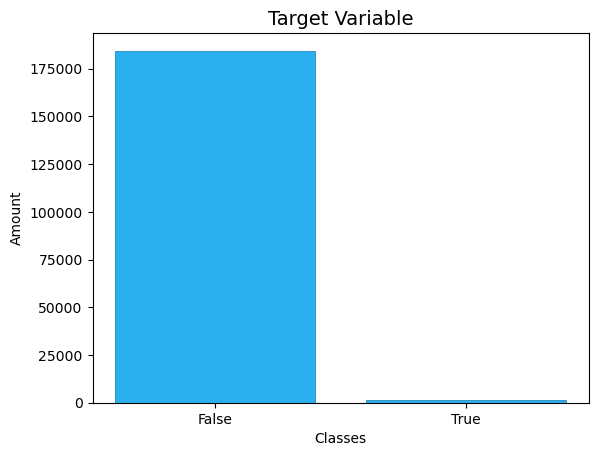

In [77]:
plt.bar(['False', 'True'], data.connected.value_counts().values, facecolor = '#2ab0ee', edgecolor='#167aaa', linewidth=0.5)
plt.title('Target Variable', fontsize=14)
plt.xlabel('Classes')
plt.ylabel('Amount')
plt.show()

In [75]:
data['pre_morph_embeddings'].isna() == True

0         False
1         False
2         False
3         False
4         False
          ...  
185827    False
185828    False
185829    False
185830    False
185831    False
Name: pre_morph_embeddings, Length: 185832, dtype: bool

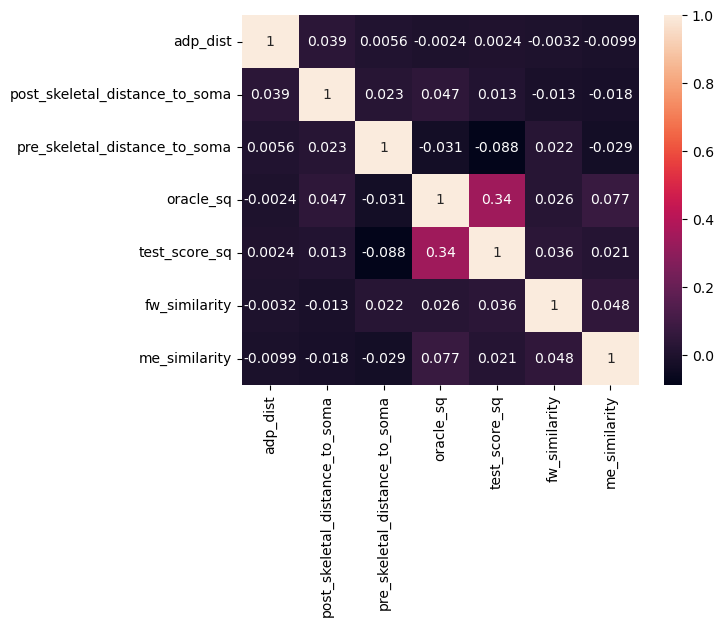

In [150]:
sns.heatmap(data[['adp_dist',
       'post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma',
       'oracle_sq', 'test_score_sq',
       'fw_similarity', 'me_similarity']].corr(), annot=True)
plt.show()

## Train

In [166]:
## New Pipeline for TreeBased Methods?

numerical_features = ['adp_dist',
       'post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma',
       'oracle_sq', 'test_score_sq',
       'fw_similarity', 'me_similarity']

categorical_features = ['projection_group', 'compartment']

features = numerical_features + categorical_features


#Pipeline by feature type
numerical_transformer = Pipeline(steps=[("scaler", MinMaxScaler())])
categorical_transformer = Pipeline(steps=[("encoder", OneHotEncoder())])

#preprocessor
preprocessor = ColumnTransformer(transformers=[
       ('num', numerical_transformer, numerical_features),
       ('cat', categorical_transformer, categorical_features)
])


## Default Classifiers + Benchmark 

In [97]:
logistic_regression_l1 = LogisticRegression(random_state=42, penalty = "l1", solver='saga')
logistic_regression_l2 = LogisticRegression(random_state=42, penalty = "l2", solver='saga')
logistic_regression = LogisticRegression(n_jobs=-1)
random_forest = RandomForestClassifier(n_jobs=-1)
adaboost = AdaBoostClassifier()
gboost = GradientBoostingClassifier()
xgboost = XGBClassifier(n_jobs=-1)
naive_bayes = GaussianNB()
bagging = BaggingClassifier(n_jobs= -1)
linear_svm = CalibratedClassifierCV(LinearSVC(max_iter=10000),method= "isotonic")
poly_svm = CalibratedClassifierCV(SVC(kernel = 'poly', max_iter=10000),method= "isotonic")

classifiers = [logistic_regression_l1, logistic_regression_l2, logistic_regression, random_forest, xgboost,
                adaboost, gboost, naive_bayes, bagging, linear_svm, poly_svm]
classifiers_names = ['L1 Logistic Regression','L2 Logistic Regression','Logistic Regression', 'Random Forest','XGBoost', 
                     'AdaBoost', 'Gradient Boost','Naive Bayes', 'Bagging', 'Linear SVM', 'Polynomial SVM']

In [98]:
# split into a train and test set 
#(Even though we're working with the competition training set, you may want to have your own internal train and test sets.)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=1)


# oversample connected neuron pairs
oversample = RandomOverSampler(random_state=0)
#oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(
    train_data[features], train_data["connected"]
)

# Need to fix! Transform then oversample
scores = []
for i in range(len(classifiers)):
    pipe = Pipeline(steps = [('preprocessor', preprocessor),
                     ('model', classifiers[i])
])
    y_pred = pipe.fit(X_resampled, y_resampled).predict_proba(test_data[features])[:, 1]
    scores.append(round(balanced_accuracy_score(test_data['connected'], y_pred > .5), 3))
    print((classifiers_names[i], round(balanced_accuracy_score(test_data['connected'], y_pred > .5), 3)))    

pd.DataFrame({'Classifier': classifiers_names, 'Balanced Accuracy Score': scores}).sort_values('Balanced Accuracy Score', ascending=False)

('L1 Logistic Regression', 0.783)
('L2 Logistic Regression', 0.783)
('Logistic Regression', 0.783)
('Random Forest', 0.5)
('XGBoost', 0.635)
('AdaBoost', 0.775)
('Gradient Boost', 0.789)
('Naive Bayes', 0.734)
('Bagging', 0.501)
('Linear SVM', 0.781)
('Polynomial SVM', 0.72)


,Classifier,Balanced Accuracy Score
6,Gradient Boost,0.789
0,L1 Logistic Regression,0.783
1,L2 Logistic Regression,0.783
2,Logistic Regression,0.783
9,Linear SVM,0.781
5,AdaBoost,0.775
7,Naive Bayes,0.734
10,Polynomial SVM,0.720
4,XGBoost,0.635
8,Bagging,0.501


## Tuning Logistic Regression

In [200]:
# split into a train and test set 
#(Even though we're working with the competition training set, you may want to have your own internal train and test sets.)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=1)

preprocessor.fit(train_data[features], train_data['connected'])
X_transformed = preprocessor.transform(train_data[features])



# oversample connected neuron pairs
oversample = RandomOverSampler(random_state=0)
#oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(
    X_transformed, train_data["connected"]
)




param_grid = {
    'C' : list(np.logspace(-3,1, 5)),
    'l1_ratio' : [0.25, 0.5, 0.75]

}

grid = GridSearchCV(LogisticRegression(penalty ='elasticnet', solver= 'saga'),
                     param_grid = param_grid, scoring = balanced_accuracy_score)

params = grid.fit(X_resampled, y_resampled).best_params_
print(grid.best_estimator_)

LogisticRegression(C=0.001, l1_ratio=0.25, penalty='elasticnet', solver='saga')


In [201]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.362482,0.084809,0.001801,0.003125,0.001,0.25,"{'C': 0.001, 'l1_ratio': 0.25}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2.289031,0.111184,0.000200,0.000400,0.001,0.5,"{'C': 0.001, 'l1_ratio': 0.5}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,2.036857,0.089334,0.000200,0.000400,0.001,0.75,"{'C': 0.001, 'l1_ratio': 0.75}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,2.505810,0.276832,0.000199,0.000398,0.01,0.25,"{'C': 0.01, 'l1_ratio': 0.25}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,2.598031,0.124126,0.000000,0.000000,0.01,0.5,"{'C': 0.01, 'l1_ratio': 0.5}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
5,2.495344,0.134086,0.000000,0.000000,0.01,0.75,"{'C': 0.01, 'l1_ratio': 0.75}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
6,2.623605,0.433585,0.000401,0.000491,0.1,0.25,"{'C': 0.1, 'l1_ratio': 0.25}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
7,2.342752,0.162671,0.000000,0.000000,0.1,0.5,"{'C': 0.1, 'l1_ratio': 0.5}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
8,2.347034,0.083377,0.000200,0.000399,0.1,0.75,"{'C': 0.1, 'l1_ratio': 0.75}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
9,4.406675,0.061319,0.000401,0.000492,1.0,0.25,"{'C': 1.0, 'l1_ratio': 0.25}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


In [159]:

preprocessor.fit(train_data[features], train_data['connected'])
X_transformed = preprocessor.transform(train_data[features])



# oversample connected neuron pairs
oversample = RandomOverSampler(random_state=0)
#oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(
    X_transformed, train_data["connected"]
)

#best_logistic_regression = LogisticRegression(C=0.7196856730011514, l1_ratio=0.75, penalty='elasticnet',solver='saga')

best_logistic_regression = LogisticRegression(C=0.001, l1_ratio=0, penalty='elasticnet', solver='saga')

best_logistic_regression.fit(X_resampled, y_resampled)

# predict on test data
test_data["pred"] = best_logistic_regression.predict_proba(preprocessor.transform(test_data[features]))[:, 1]

# compute accuracy
print(f"balanced accuracy: {balanced_accuracy_score(test_data['connected'], test_data['pred'] > .5)}")

balanced accuracy: 0.7803688956772482


## Tunning Gboost

In [193]:
# split into a train and test set 
#(Even though we're working with the competition training set, you may want to have your own internal train and test sets.)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=1)



preprocessor.fit(train_data[features])
X_transformed = preprocessor.transform(train_data[features])


# oversample connected neuron pairs
oversample = RandomOverSampler(random_state=0)
#oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(
    X_transformed, train_data["connected"]
)



param_grid = {
    'n_estimators': [50, 150, 200],
    'max_depth': [5, 10, None],
    'subsample': [0.5, 1]
}

grid = GridSearchCV(GradientBoostingClassifier(), param_grid = param_grid, n_jobs= -1, scoring = balanced_accuracy_score)

params = grid.fit(X_resampled, y_resampled).best_params_
print(grid.best_estimator_)

GradientBoostingClassifier(max_depth=5, n_estimators=50, subsample=0.5)


In [198]:
pd.DataFrame(grid.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_n_estimators', 'param_subsample', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [194]:

preprocessor.fit(train_data[features])
X_transformed = preprocessor.transform(train_data[features])



# oversample connected neuron pairs
oversample = RandomOverSampler(random_state=0)

X_resampled, y_resampled = oversample.fit_resample(
    X_transformed, train_data["connected"]
)


best_gboost = GradientBoostingClassifier(max_depth=5, n_estimators=50, subsample=0.5)
best_gboost.fit(X_resampled, y_resampled)

# predict on test data
test_data["pred"] = best_gboost.predict_proba(preprocessor.transform(test_data[features]))[:, 1]

# compute accuracy
print(f"balanced accuracy: {balanced_accuracy_score(test_data['connected'], test_data['pred'] > .5)}")

balanced accuracy: 0.7775632634903973


## Old Stuff (Making A feature with logistic reg)

In [ ]:

# oversample connected neuron pairs
oversample = RandomOverSampler(random_state=0)
#oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(
    train_data[features], train_data["connected"]
)


pipe = Pipeline(steps = [('preprocessor', preprocessor),
                     ('model', classifiers[i])])

pipe.fit(X_resampled, y_resampled)

# predict on test data
test_data["pred"] = pipe.predict_proba(test_data[features])[:, 1]

# compute accuracy
print(f"balanced accuracy: {balanced_accuracy_score(test_data['connected'], test_data['pred'] > .5)}")

In [29]:
#set prediction variables
vars = [        'AL_to_AL', 'AL_to_RL', 'AL_to_V1', 'RL_to_AL', 'RL_to_RL', 'RL_to_V1',
       'V1_to_AL', 'V1_to_RL', 'V1_to_V1', 'apical', 'apical_shaft',
       'apical_tuft', 'axon', 'basal', 'oblique', 'soma']

#'adp_dist',
#       'post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma',
#       'pre_oracle', 'post_oracle',
#       'fw_similarity', 'test_score_sq', 

# split into a train and test set 
#(Even though we're working with the competition training set, you may want to have your own internal train and test sets.)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=1)


# oversample connected neuron pairs
oversample = RandomOverSampler(random_state=0)
#oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(
    train_data[vars], train_data["connected"]
)


# create pipeline
pipe = Pipeline(
  [("scaler", MinMaxScaler()), ("model", LogisticRegression(random_state=42, penalty = "l1", solver='saga'))]
)


# Encoder is sparse, regularization is recommended
# fit model
pipe.fit(X_resampled, y_resampled)

# predict on test data
test_data["pred"] = pipe.predict_proba(test_data[vars])[:, 1]

# compute accuracy
print(f"balanced accuracy: {balanced_accuracy_score(test_data['connected'], test_data['pred'] > .5)}")


balanced accuracy: 0.6221801161257493


## predict_proba as a feature

In [16]:
#train with all data
X_resampled, y_resampled = oversample.fit_resample(
    data[features], data["connected"]
)

pipe.fit(X_resampled,  y_resampled)

data["logr_pred"] = pipe.predict_proba(data[features])[:, 1]


c:\Users\danie\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


## Training models with logr_pr as a feature

In [21]:
#set prediction variables
vars = [ 'adp_dist',
       'post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma',
       'pre_oracle', 'post_oracle',
       'fw_similarity', 'test_score_sq', 'logr_pred']


# split into a train and test set 
#(Even though we're working with the competition training set, you may want to have your own internal train and test sets.)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=1)


# oversample connected neuron pairs
oversample = RandomOverSampler(random_state=0)
#oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(
    train_data[vars], train_data["connected"]
)


# create pipeline
pipe = Pipeline(
  [("scaler", MinMaxScaler()), ("model",  CalibratedClassifierCV(SVC(kernel ='linear', random_state=42, max_iter= 100000 ),method= "isotonic"))]
)


# Encoder is sparse, regularization is recommended
# fit model
pipe.fit(X_resampled, y_resampled)

# predict on test data
test_data["pred"] = pipe.predict_proba(test_data[vars])[:, 1]

# compute accuracy
print(f"balanced accuracy: {balanced_accuracy_score(test_data['connected'], test_data['pred'] > .5)}")

## Making Leaderboard Submission

In [186]:
#we need to first load and merge the leaderboard data to have the same format as the training set
lb_data = pd.read_csv("./leaderboard_data.csv")

In [187]:
lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [181]:
lb_data.shape


(42593, 33)

In [182]:
lb_data.head()

,ID,axonal_coor_x,axonal_coor_y,axonal_coor_z,dendritic_coor_x,dendritic_coor_y,dendritic_coor_z,adp_dist,post_skeletal_distance_to_soma,pre_skeletal_distance_to_soma,...,pre_nucleus_z,post_nucleus_x,post_nucleus_y,post_nucleus_z,pre_nucleus_id,post_nucleus_id,pre_feature_weights,post_feature_weights,pre_morph_embeddings,post_morph_embeddings
0,0,527499,544761,912282,529457,543459,916958,4783.37,239163.00,178032.0,...,861240,566528,777344,920800,582471,199477,"[0.19683373, 0.19128098, 0.49339047, -0.029781...","[-0.03441501, 0.41964892, 0.23311342, 0.327173...","[0.5603107213973999, -0.3908874094486236, -0.1...","[1.132591724395752, -0.0064769592136144, -0.67..."
1,1,1269890,471870,837816,1271230,469651,841045,4060.72,294573.00,1193910.0,...,861240,1196352,492736,919560,582471,518848,"[0.19683373, 0.19128098, 0.49339047, -0.029781...","[-0.03917461, -0.1830603, -0.3704222, 0.183293...","[0.5603107213973999, -0.3908874094486236, -0.1...","[1.0723994970321655, -0.7540942430496216, 0.11..."
2,2,666057,469875,925239,665387,467214,923430,2912.80,4102.75,387714.0,...,861240,669760,470336,913720,582471,256716,"[0.19683373, 0.19128098, 0.49339047, -0.029781...","[-0.66653997, 0.5036552, 0.047438737, 0.181578...","[0.5603107213973999, -0.3908874094486236, -0.1...","[-0.0201839506626129, -0.2563340067863464, 0.1..."
3,3,696633,453516,925806,696648,453417,921875,3272.83,31123.00,424714.0,...,861240,669760,470336,913720,582471,256716,"[0.19683373, 0.19128098, 0.49339047, -0.029781...","[-0.66653997, 0.5036552, 0.047438737, 0.181578...","[0.5603107213973999, -0.3908874094486236, -0.1...","[-0.0201839506626129, -0.2563340067863464, 0.1..."
4,4,567525,585921,888426,570714,583676,891264,4441.75,114201.00,250411.0,...,861240,672384,609728,932720,582471,260802,"[0.19683373, 0.19128098, 0.49339047, -0.029781...","[-0.40308818, 0.20905656, 0.25083357, -0.19731...","[0.5603107213973999, -0.3908874094486236, -0.1...","[-0.0254557952284812, 0.7573301792144775, -0.2..."


In [188]:
feature_engineering(lb_data)
lb_data.columns

Index(['ID', 'axonal_coor_x', 'axonal_coor_y', 'axonal_coor_z',
       'dendritic_coor_x', 'dendritic_coor_y', 'dendritic_coor_z', 'adp_dist',
       'post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma',
       'pre_oracle', 'pre_test_score', 'pre_rf_x', 'pre_rf_y', 'post_oracle',
       'post_test_score', 'post_rf_x', 'post_rf_y', 'compartment',
       'pre_brain_area', 'post_brain_area', 'pre_nucleus_x', 'pre_nucleus_y',
       'pre_nucleus_z', 'post_nucleus_x', 'post_nucleus_y', 'post_nucleus_z',
       'pre_nucleus_id', 'post_nucleus_id', 'pre_feature_weights',
       'post_feature_weights', 'pre_morph_embeddings', 'post_morph_embeddings',
       'fw_similarity', 'me_similarity', 'oracle_sq', 'test_score_sq',
       'projection_group'],
      dtype='object')

In [189]:
# fit preprocessor with training data and transform X_train, X_test
preprocessor.fit(train_data[features])
X_transformed = preprocessor.transform(train_data[features])

X_test_transformed_lb = preprocessor.transform(lb_data[features])


## oversample connected neuron pairs for full training data
oversample = RandomOverSampler(random_state=0)

X_resampled, y_resampled = oversample.fit_resample(
    X_transformed, train_data["connected"]
)

#train model
best_gboost = GradientBoostingClassifier(subsample=0.5)

best_gboost.fit(X_resampled, y_resampled)


# predict on leaderboard data
lb_data["pred"] = best_gboost.predict_proba(X_test_transformed_lb)[:, 1]

#create a boolean prediction solution
lb_data["connected"] = lb_data["pred"] > .5

In [190]:
#columns should be ID, connected
submission_data = lb_data.filter(['ID','connected'])

In [191]:
import os
os.chdir(r"C:\Users\danie\OneDrive\Desktop\Fall2023\ELEC478\Competition")

In [192]:
#writing csv files
submission_data.to_csv('submission_10.csv',index=False)